In [ ]:
import numpy as np
from PIL import Image
from sklearn.neural_network import MLPClassifier
import os
from tqdm import tqdm
import pickle
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

In [ ]:
X=[]
Y=[]
for folder in tqdm(os.listdir('/train')):
  for filename in os.listdir('/train'+'/'+folder):
    img=Image.open('/train'+'/'+folder+'/'+filename)
    img=np.asarray(img).flatten()
    X.append(img)
    Y.append(folder)

for i in tqdm(range(len(X))):
    X[i]=np.append(X[i],np.zeros(1419264-len(X[i])))

#change data type to int8
for i in tqdm(range(len(X))):
    X[i]=X[i].astype('uint8')



#split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

100%|██████████| 2257/2257 [00:08<00:00, 277.38it/s]


In [ ]:
models = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,verbose=True,n_jobs=-1),
    'SGDClassifier': SGDClassifier(verbose=True,n_jobs=-1),
    'SVM': svm.SVC(gamma='scale',verbose=True),
    'DecisionTreeClassifier': tree.DecisionTreeClassifier(),
    'MLPClassifier': MLPClassifier(solver="adam", alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1,verbose=True)
}

results=[]
for name, model in tqdm(models.items()):
    kf=KFold(n_splits=5,shuffle=True,random_state=42)
    cv_results=cross_val_score(model,X_train,y_train,cv=kf)
    results.append(cv_results)



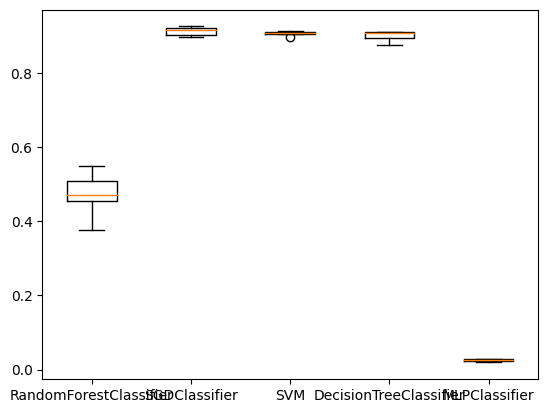

In [ ]:
plt.boxplot(results,labels=models.keys())
plt.show()

In [ ]:
sgd=SGDClassifier(n_jobs=-1,loss='hinge',alpha=0.001)
sgd.fit(X_train,y_train)
#confusion matrix
y_pred=sgd.predict(X_test)
print(classification_report(y_test,y_pred))

                precision    recall  f1-score   support

     Adialer.C       0.64      1.00      0.78        18
     Agent.FYI       1.00      0.88      0.93        16
     Allaple.A       0.96      1.00      0.98        23
     Allaple.L       1.00      1.00      1.00        23
 Alueron.gen!J       1.00      1.00      1.00        27
     Autorun.K       1.00      1.00      1.00        19
       C2LOP.P       0.89      0.53      0.67        15
   C2LOP.gen!g       0.73      0.94      0.82        17
Dialplatform.B       1.00      1.00      1.00        12
     Dontovo.A       1.00      1.00      1.00        18
      Fakerean       1.00      0.95      0.97        20
 Instantaccess       1.00      0.90      0.95        20
    Lolyda.AA1       0.96      1.00      0.98        23
    Lolyda.AA2       1.00      0.94      0.97        18
    Lolyda.AA3       0.92      1.00      0.96        12
     Lolyda.AT       0.91      1.00      0.95        21
   Malex.gen!J       1.00      0.94      0.97  

In [ ]:
#save model
pickle.dump(sgd,open('/model.sav','wb'))

In [ ]:
#load model
loaded_model=pickle.load(open('/model.sav','rb'))
calibrated_clf=CalibratedClassifierCV(loaded_model,cv='prefit')
calibrated_clf.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, n_jobs=-1),
                       cv='prefit')

In [ ]:
#save model
pickle.dump(calibrated_clf,open('/calibmodel.sav','wb'))

In [ ]:
#load model
loaded_model=pickle.load(open('/calibmodel.sav','rb'))

In [ ]:

X_verify=[]
Y_verify=[]
class_labels=[]

for folder in tqdm(os.listdir('/validation')):
  for filename in os.listdir('/validation'+'/'+folder):
    img=Image.open('/validation'+'/'+folder+'/'+filename)
    img=np.asarray(img).flatten()
    X_verify.append(img)
    Y_verify.append(folder)
  class_labels.append(folder)

for i in tqdm(range(len(X_verify))):
    X_verify[i]=np.append(X_verify[i],np.zeros(1419264-len(X_verify[i])))

#change data type to int8
for i in tqdm(range(len(X_verify))):
    X_verify[i]=X_verify[i].astype('uint8')

y_pred=loaded_model.predict(X_verify)
print(classification_report(Y_verify,y_pred))

100%|██████████| 935/935 [00:01<00:00, 591.98it/s]


                precision    recall  f1-score   support

     Adialer.C       0.61      1.00      0.76        25
     Agent.FYI       1.00      1.00      1.00        25
     Allaple.A       1.00      0.98      0.99       125
     Allaple.L       1.00      0.99      0.99       100
 Alueron.gen!J       0.93      1.00      0.96        25
     Autorun.K       1.00      1.00      1.00        25
       C2LOP.P       0.83      0.40      0.54        25
   C2LOP.gen!g       0.67      0.96      0.79        25
Dialplatform.B       1.00      1.00      1.00        25
     Dontovo.A       0.96      1.00      0.98        25
      Fakerean       0.99      0.99      0.99        75
 Instantaccess       1.00      0.97      0.99        75
    Lolyda.AA1       1.00      1.00      1.00        60
    Lolyda.AA2       1.00      1.00      1.00        25
    Lolyda.AA3       0.93      1.00      0.96        25
     Lolyda.AT       1.00      1.00      1.00        25
   Malex.gen!J       1.00      0.96      0.98  

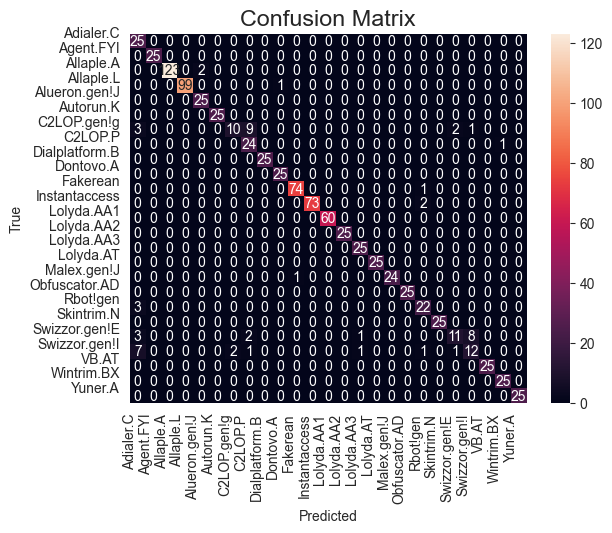

In [ ]:
#confusion matrix as heatmap of loaded model
cm=confusion_matrix(Y_verify,y_pred)
sn.heatmap(cm,annot=True,fmt='d')
#labels, title and ticks
sn.set(font_scale=1.4)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
#class labels
plt.xticks(range(25),class_labels,rotation=90)
plt.yticks(range(25),class_labels,rotation=0)

#save as png
plt.savefig('confusion_matrix.png')

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

#load image
img=Image.open('/dog.jpg')
img=np.asarray(img).flatten()
img=np.append(img,np.zeros(1419264-len(img)))
img=img.astype('uint8')

#if any class probability is greater than 0.2 then it is not malware
if np.max(loaded_model.predict_proba([img]))<0.1:
  print('Not Malware')
else:
  #if malware then predict class
    print(loaded_model.predict([img]))


Not Malware
